https://discourse.pymc.io/t/sampling-uniformly-in-a-triangular-support/765/

In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import seaborn as sns
import pystan

%pylab inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [29]:
ordered = pm.distributions.transforms.Ordered()
testval = np.asarray([-1.,1.,4.])
with pm.Model() as m:
    x = pm.Normal('x', 0., 1., 
                  shape=3,
                  transform=ordered, 
                  testval=testval)

In [36]:
ordered.forward(testval).eval()

array([-1.        ,  0.69314718,  1.09861229])

In [37]:
ordered.jacobian_det(ordered.forward(testval)).eval()

array(1.79175947)

In [30]:
pm.Normal.dist(0., 1.).logp(testval).eval()

array([-1.41893853, -1.41893853, -8.91893853])

In [38]:
(pm.Normal.dist(0., 1.).logp(testval).sum() + ordered.jacobian_det(ordered.forward(testval))).sum().eval()

array(-9.96505613)

In [32]:
(pm.Normal.dist(0., 1.).logp(testval).eval()).sum()

-11.756815599614018

In [34]:
(pm.Normal.dist(0., 1.).logp(testval)+ordered.jacobian_det(ordered.forward(testval))).eval().sum()

-6.381537191929853

In [35]:
m.logp(m.test_point)

array(-6.38153719)

In [2]:
with pm.Model() as m:
    x = pm.Uniform('x', 0., 1., shape=2)
    pm.Potential('ordered', tt.switch(x[1]-x[0] < 0, -np.inf, 0))
    tr = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_interval__]
INFO:pymc3:NUTS: [x_interval__]
100%|██████████| 1000/1000 [00:03<00:00, 274.00it/s]
There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
There were 337 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 337 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


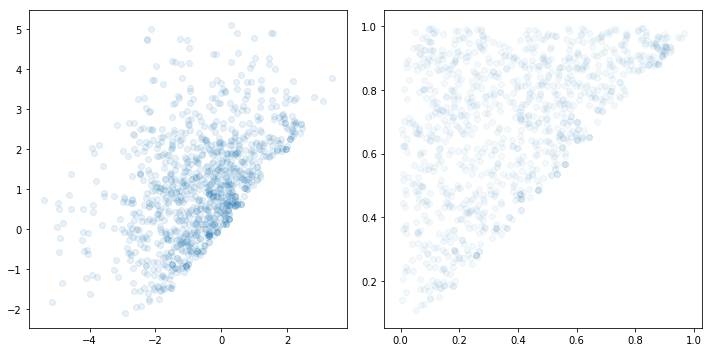

In [3]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr['x_interval__'][:, 0], tr['x_interval__'][:, 1], alpha=.1)
ax[1].scatter(tr['x'][:, 0], tr['x'][:, 1], alpha=.05)
plt.tight_layout();

In [4]:
def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

def normcdf1(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.cos(angle) * thetap1) - (np.sin(angle) * tt.abs_(thetap2)))

def normcdf2(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.sin(angle) * thetap1) + (np.cos(angle) * tt.abs_(thetap2)))

with pm.Model() as m1:
    thetap = pm.MvNormal('thetap', mu=0., cov=np.eye(2), shape=2)
    
    x1 = pm.Deterministic('x1', normcdf1(thetap[0], thetap[1]))
    x2 = pm.Deterministic('x2', normcdf2(thetap[0], thetap[1]))

    tr1 = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetap]
INFO:pymc3:NUTS: [thetap]
100%|██████████| 1000/1000 [00:04<00:00, 235.44it/s]


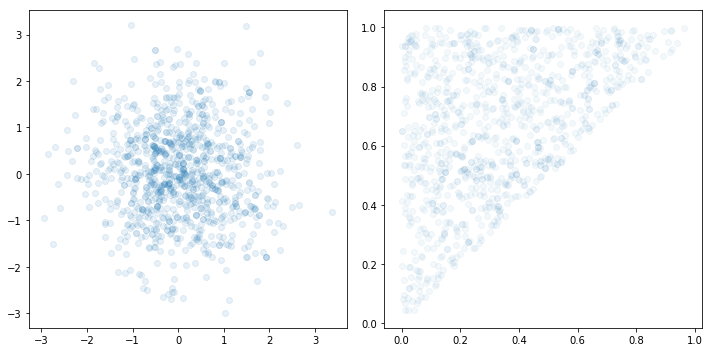

In [5]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr1['thetap'][:, 0], tr1['thetap'][:, 1], alpha=.1)
ax[1].scatter(tr1['x1'], tr1['x2'], alpha=.05)
plt.tight_layout();

In [6]:
datadict = {}
datadict['N'] = 2
stan_m = """
    data {
        int<lower=1> N;
    }
    parameters {
        ordered[N] x;
    }
    model {
        x ~ uniform(0, 1);
        // target += uniform_lpdf(x | 0, 1);
    }
    """

tr_stan = pystan.stan(model_code=stan_m, data=datadict,
                      iter=5000, warmup=1000, 
                      chains=4, n_jobs=4, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a354c77b7a6aa37371be175bb3cd19cd NOW.


In file included from /var/folders/r9/tw7dcc6s5bn6t81d0cr9nyxm0000gp/T/tmpuonkkstd/stanfit4anon_model_a354c77b7a6aa37371be175bb3cd19cd_5615160690333248029.cpp:599:
In file included from /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/r9/tw7dcc6s5bn6t81d0cr9nyxm0000gp/T/tmpuonkkstd/stanfit4anon_model

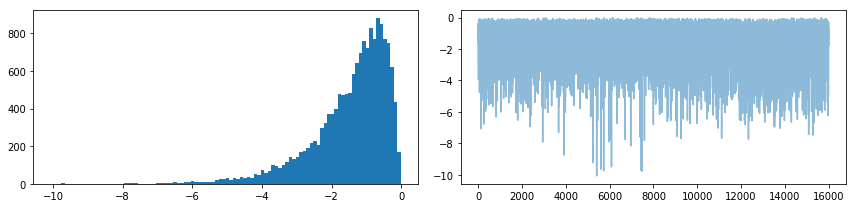

In [7]:
tr_x = tr_stan.extract()['x']
lnp = tr_stan.extract()['lp__']

_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

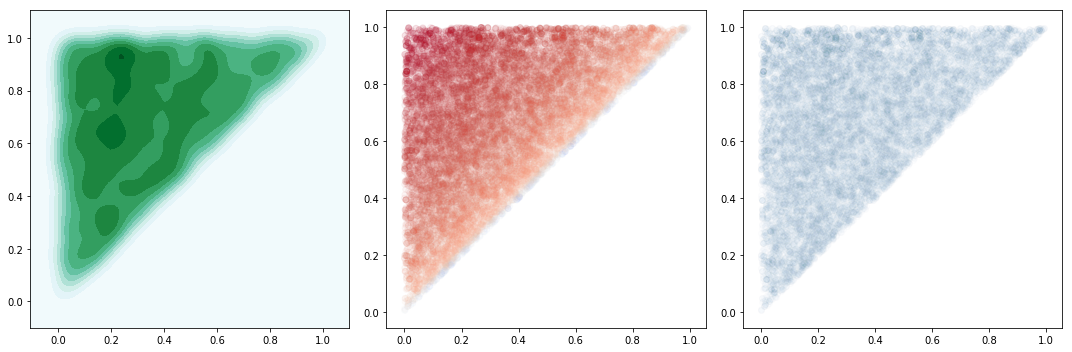

In [8]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(tr_x[:, 0], tr_x[:, 1], shade=True, ax=ax[0])
ax[1].scatter(tr_x[:, 0], tr_x[:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(tr_x[:, 0], tr_x[:, 1], alpha=.01)
plt.tight_layout();

In [9]:
x = np.random.rand(1, 5).squeeze()
x

array([0.91902638, 0.24208974, 0.93833368, 0.47205778, 0.54747846])

In [10]:
def backward1(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        if i>0:
            y[i] = y[i-1] + np.exp(x[i])
    return y

y = backward1(x)
y

array([0.91902638, 2.19293488, 4.74865411, 6.35194412, 8.08083219])

In [11]:
def backward2(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    y[1:] = np.exp(x[1:])
    return np.cumsum(y)

y = backward2(x)
y

array([0.91902638, 2.19293488, 4.74865411, 6.35194412, 8.08083219])

In [12]:
def forward2(y):
    x = np.zeros_like(y)
    x[0] = y[0]
    x[1:] = np.log(y[1:] - y[:-1])
    return x

x2 = forward2(y)
x2

array([0.91902638, 0.24208974, 0.93833368, 0.47205778, 0.54747846])

In [40]:
class Ordered(pm.distributions.transforms.Transform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        y = np.zeros_like(x)
        y[0] = x[0]
        y[1:] = np.log(x[1:] - x[:-1])
        return y

    def jacobian_det(self, y):
        return tt.sum(y[1:])# / (tt.ones_like(y)*y.shape[-1]) <-- potential fix
    
class Chained(pm.distributions.transforms.Transform):
    def __init__(self, transform_list):
        self.transform_list = transform_list
        self.name = '_'.join([transf.name for transf in self.transform_list])

    def forward(self, x):
        y = x
        for transf in self.transform_list:
            y = transf.forward(y)
        return y

    def forward_val(self, x, point=None):
        y = x
        for transf in self.transform_list:
            y = transf.forward_val(y)
        return y

    def backward(self, y):
        x = y
        for transf in reversed(self.transform_list):
            x = transf.backward(x)
        return x

    def jacobian_det(self, y):
        y_ = y
        det = 0.
        for transf in reversed(self.transform_list):
            det += transf.jacobian_det(y_)
            y_ = transf.backward(y_)
        return det

In [41]:
Order = Ordered()
upper, lower = 0., 1.
Interval = pm.distributions.transforms.Interval(upper, lower)
Logodd = pm.distributions.transforms.LogOdds()
with pm.Model() as m2:
    chain_tran = Chained([Logodd, Order])
    x = pm.Uniform('x', 0., 1., shape=2,
                   transform=chain_tran,
                   testval=[0.1, 0.9])
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr2 = pm.sample(5000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_logodds_ordered__]
INFO:pymc3:NUTS: [x_logodds_ordered__]
100%|██████████| 5500/5500 [00:07<00:00, 758.69it/s]
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [42]:
varnames = tr2.varnames
varnames

['x_logodds_ordered__', 'x', 'jacobian']

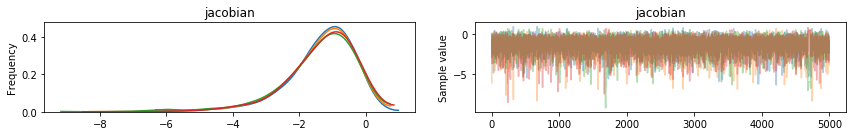

In [43]:
pm.traceplot(tr2, varnames=['jacobian']);

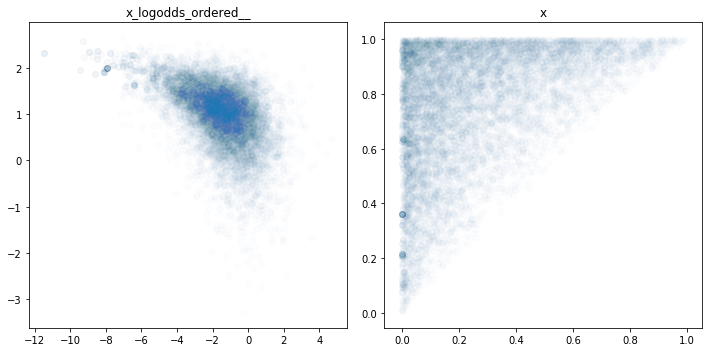

In [44]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(tr2[varname][:, 0], tr2[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

In [19]:
with pm.Model() as mtest:
    x = pm.Flat('x_logodds_ordered__', shape=2, testval=[2., 1.])
    
    x1 = Order.backward(x)
    x2 = pm.Deterministic('x', Logodd.backward(x1))
    
    pm.Potential('p1', Order.jacobian_det(x))
    pm.Potential('logp', pm.Uniform.dist(upper, lower).logp(x2))
    pm.Potential('p2', Logodd.jacobian_det(x1))
    
    pm.Deterministic('jacobian', Order.jacobian_det(x) + Logodd.jacobian_det(x1))
    
    trtest = pm.sample(5000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_logodds_ordered__]
INFO:pymc3:NUTS: [x_logodds_ordered__]
100%|██████████| 5500/5500 [00:08<00:00, 667.38it/s]
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [20]:
varnames = trtest.varnames
varnames

['x_logodds_ordered__', 'x', 'jacobian']

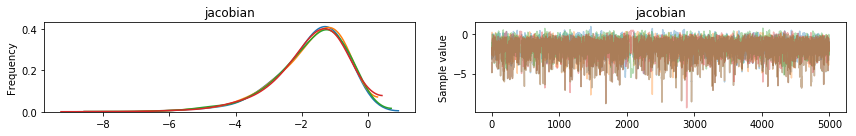

In [21]:
pm.traceplot(trtest, varnames=['jacobian']);

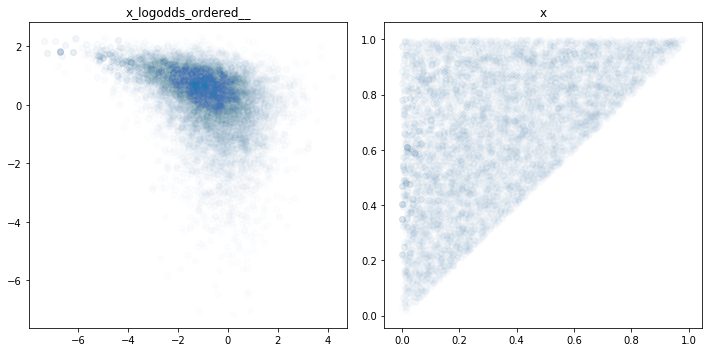

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(trtest[varname][:, 0], trtest[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

The Jacobian computed by hand seems to be correct, now try to pin down where went wrong when chaining the transformation together

In [23]:
x = np.asarray([2., 1.])
det = Order.jacobian_det(x) + Logodd.jacobian_det(Order.backward(x))
det.eval()

array([-1.25385602, -3.73606357])

In [24]:
chain_tran.jacobian_det(x).eval()

array([-1.25385602, -3.73606357])

In [25]:
# testpoint = m2.test_point
testpoint = mtest.test_point
testpoint

{'x_logodds_ordered__': array([2., 1.])}

In [26]:
m2.logp(testpoint)

array(-4.98991959)

In [27]:
mtest.logp(testpoint)

array(-5.98991959)

The model logp is different

In [28]:
factors = [var.logpt for var in m2.basic_RVs] + m2.potentials
func1 = theano.function(m2.basic_RVs, factors)
func1(np.asarray([2., 1.]))

[array(-4.98991959)]

In [29]:
factors = [var.logpt for var in mtest.basic_RVs] + mtest.potentials
func2 = theano.function(mtest.basic_RVs, factors)
func2(np.asarray([2., 1.]))

[array(0.), array(1.), array([0., 0.]), array([-2.25385602, -4.73606357])]

In [30]:
np.sum([np.sum(out) for out in func2(np.asarray([2., 1.]))])

-5.989919587258818

In [31]:
x0 = m2.basic_RVs[0]
x0.distribution.logp(x).eval()

array([-1.25385602, -3.73606357])

In [31]:
logp = m2.logp
lnp = np.array([logp(tr2.point(i,chain=c)) for c in tr2.chains for i in range(len(tr2))])

In [32]:
pm.distributions.transforms.LogOdds??

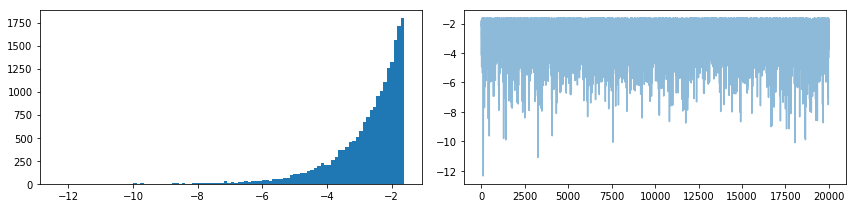

In [32]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

In [33]:
logp = mtest.logp
lnp = np.array([logp(trtest.point(i,chain=c)) for c in trtest.chains for i in range(len(trtest))])

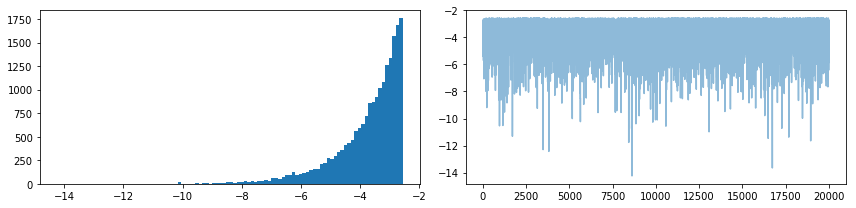

In [34]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

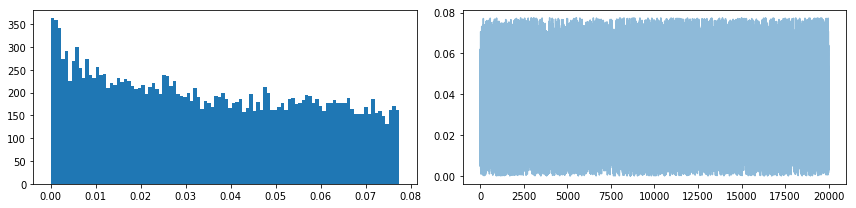

In [35]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(np.exp(lnp), 100)
ax[1].plot(np.exp(lnp), alpha=.5);
plt.tight_layout();

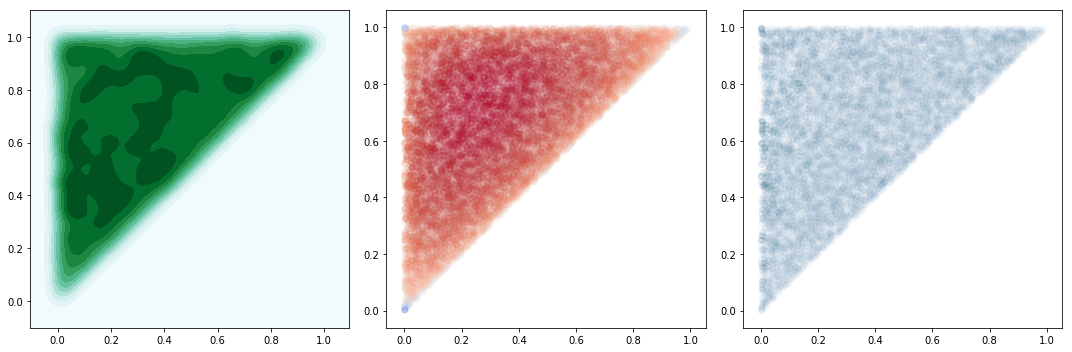

In [36]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

varname = 'x'
sns.kdeplot(trtest[varname][:, 0], trtest[varname][:, 1], shade=True, ax=ax[0])
ax[1].scatter(trtest[varname][:, 0], trtest[varname][:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(trtest[varname][:, 0], trtest[varname][:, 1], cmap=plt.cm.coolwarm,
           alpha=.01)
plt.tight_layout();

In [63]:
import tensorflow as tf
from tensorflow.contrib.distributions.python.ops.bijectors.ordered import Ordered
from tensorflow.contrib.distributions.python.ops.bijectors.sigmoid import Sigmoid
from tensorflow.contrib.distributions.python.ops.bijectors.chain import Chain

from scipy import special
import numpy as np
# x = np.asarray([1.88535668, -1.34137155, -1.07726682, -0.4407823, -1.70935385])
# y = special.expit(x)
y = np.sort(np.random.rand(5))

sigmoid = Sigmoid()
ordered = Ordered()
chain = Chain((sigmoid, ordered))

sess = tf.Session()

In [64]:
Sigmoid??

In [65]:
sess.run(sigmoid.inverse(y))

array([-1.16196787,  0.13362878,  1.30444068,  1.40962033,  4.98870874])

In [66]:
sess.run(chain.inverse(y))

array([-1.16196787e+00, -1.89994208e-02,  3.66662764e+00,  7.76102824e+00,
        1.54507841e+02])

In [67]:
sess.run(ordered.inverse(sigmoid.inverse(y)))

array([-1.16196787e+00, -1.89994208e-02,  3.66662764e+00,  7.76102824e+00,
        1.54507841e+02])

In [68]:
sess.run(chain.inverse_log_det_jacobian(y, event_ndims=1))

19.567066556315183

In [69]:
sess.run(sigmoid.inverse_log_det_jacobian(y, event_ndims=1))

11.730668020917207

In [70]:
sess.run(ordered.inverse_log_det_jacobian(sigmoid.inverse(y), event_ndims=1))

7.8363985353979775

In [71]:
class Ordered(pm.distributions.transforms.Transform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        y = np.zeros_like(x)
        y[0] = x[0]
        y[1:] = np.log(x[1:] - x[:-1])
        return y

    def jacobian_det(self, y):
        return tt.sum(y[1:]) / (tt.ones(y.shape) * y.shape[-1]) # <-- quick hack


class Sigmoid(pm.distributions.transforms.Transform):
    name = "ordered"

    def backward(self, y):
        return tt.log(y) - tt.log1p(-y)

    def forward(self, x):
        return tt.nnet.sigmoid(x)

    def forward_val(self, x, point=None):
        return special.expit(x)

    def jacobian_det(self, y):
        return -tt.log(y) - tt.log1p(-y)


class Chained(pm.distributions.transforms.Transform):
    def __init__(self, transform_list):
        self.transform_list = transform_list
        self.name = '_'.join([transf.name for transf in self.transform_list])

    def forward(self, x):
        y = x
        for transf in self.transform_list:
            y = transf.forward(y)
        return y

    def forward_val(self, x, point=None):
        y = x
        for transf in self.transform_list:
            y = transf.forward_val(y)
        return y

    def backward(self, y):
        x = y
        for transf in reversed(self.transform_list):
            x = transf.backward(x)
        return x

    def jacobian_det(self, y):
        y_ = y
        det = 0.
        for transf in reversed(self.transform_list):
            det += transf.jacobian_det(y_)
            y_ = transf.backward(y_)
        return det

In [73]:
ordered = Ordered()
sigmoid = Sigmoid()
chain_tran = Chained([ordered, sigmoid])
chain_tran.jacobian_det(y).eval()

array([3.27367857, 2.95803491, 3.35183853, 3.4139434 , 6.56957114])

In [74]:
chain_tran.jacobian_det(y).sum().eval()

array(19.56706656)

https://discourse.pymc.io/t/order-statistics-in-pymc3/617/3

[0 1 4 2 3]
[[1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0]
 [0 1 1 3 0 1 3 1 1 1 1 1 0 4 1 1 1 1 1 1 1 0 1 3 1 0 1 0 1 1]
 [4 4 4 1 4 4 1 4 2 4 3 4 3 1 4 4 3 3 4 3 3 3 4 4 3 4 3 4 3 3]
 [3 2 3 4 3 3 4 3 4 3 2 3 4 2 3 3 4 2 2 4 4 4 3 1 2 3 2 3 4 4]
 [2 3 2 2 2 2 2 2 3 2 4 2 2 3 2 2 2 4 3 2 2 2 2 2 4 2 4 2 2 2]]


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [latent_ordered2d__, mu_hat]
INFO:pymc3:NUTS: [latent_ordered2d__, mu_hat]
100%|██████████| 1000/1000 [00:12<00:00, 81.28it/s]


The true ranking is: 
[0 1 4 2 3]
The Latent mean is: 
[0.   2.39 5.96 6.42 5.6 ]
The estimated ranking is: 
[0 1 4 2 3]


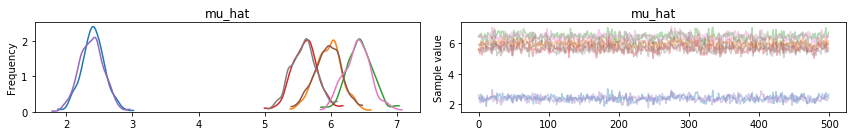

In [34]:
# data
K = 5 # number of items being ranked
J = 100 # number of raters
yreal = np.argsort(np.random.randn(K, 1), axis=0)
print(yreal.squeeze())
y = np.argsort(yreal + np.random.randn(K, J), axis=0)
print(y[:, :30])

class Ordered2D(pm.distributions.transforms.Transform):
    name = "ordered2d"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0,:], x[0,:])
        out = tt.inc_subtensor(out[1:,:], tt.log(x[1:,:] - x[:-1,:]))
        return out
    
    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0,:], y[0,:])
        out = tt.inc_subtensor(out[1:,:], tt.exp(y[1:,:]))
        return tt.cumsum(out, axis=0)
    
    def jacobian_det(self, y):
        return tt.sum(y[1:,:], axis=0, keepdims=True)/(tt.ones(y.shape)*y.shape[-1])

# transformed data{
y_argsort = np.argsort(y, axis=0)

with pm.Model():
    mu_hat = pm.Normal('mu_hat', 0, 1, shape=K-1)
    # set first value to 0 to avoid unidentified model
    mu = tt.concatenate([[0.], mu_hat])
    #sd = pm.HalfCauchy('sigma', 1.)
    latent = pm.Normal('latent',
                       mu=mu[y_argsort],
                       sd=1., # using sd does not work yet
                       transform=Ordered2D(), 
                       shape=(K,J),
                       testval=np.repeat(np.arange(K)[:,None], J, axis=1))
                        # There are some problems with Ordered 
                        # right now, you need to give a testval
    trace = pm.sample()
pm.traceplot(trace, varnames=['mu_hat']);

print('The true ranking is: ')
print(yreal.flatten())
print('The Latent mean is: ')
latentmu = np.hstack(([0], pm.summary(trace, varnames=['mu_hat'])['mean'].values))
print(np.round(latentmu,2))
print('The estimated ranking is: ')
print(np.argsort(latentmu))